In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import dataloader as dal

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# https://zhuanlan.zhihu.com/p/480348215
# 一些默认配置，使得图表更美观
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-dark')
#sns.set_style("white")
# 设置matplotlib正常显示中文
plt.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False 

In [4]:
dl = dal.dataloader()
_=dl.get_slist()
dl.filter_slist(pd.to_datetime('2014-01-01'))
dl.get_sdata_tdx('E:/s/tdx/',start="2018/01/01",end='2021/01/31')

100%|██████████| 197/197 [00:06<00:00, 32.73it/s]


open    high    low   close       volume        amount
date       code                                                            
2018-01-02 000001   12.44   13.02  12.41   12.79  208159200.0  2.856543e+09
2018-01-03 000001   12.82   12.95  12.29   12.42  296249792.0  4.006220e+09
2018-01-04 000001   12.41   12.46  12.22   12.34  185450896.0  2.454543e+09
2018-01-05 000001   12.30   12.44  12.24   12.39  121031200.0  1.603289e+09
2018-01-08 000001   12.34   12.38  11.95   12.05  215862000.0  2.806099e+09
...                   ...     ...    ...     ...          ...           ...
2021-01-25 300274   98.75  113.37  97.56  102.25   81047212.0  8.559588e+09
2021-01-26 300274   98.75  100.03  94.12   95.33   86710593.0  8.400924e+09
2021-01-27 300274   97.64  104.25  92.26  104.25   72114934.0  7.084138e+09
2021-01-28 300274   98.76  103.15  98.75   99.34   47817006.0  4.815719e+09
2021-01-29 300274  101.06  106.11  95.85  104.55   69117131.0  7.067203e+09

[145986 rows x 6 columns]

In [46]:
temp=dl.sdata.iloc[:15,:]

In [47]:
for row in temp.itertuples():
    break

In [5]:
dl.sdata['factor']=dal.alpha_6(dl.sdata)
dl.sdata['factor']=dal.shift_ndate(dl.sdata.factor,1)

In [8]:
dl.sdata['factor']

date        code  
2018-01-02  000001         NaN
2018-01-03  000001         NaN
2018-01-04  000001         NaN
2018-01-05  000001         NaN
2018-01-08  000001         NaN
                        ...   
2021-01-25  300274   -0.202411
2021-01-26  300274   -0.663228
2021-01-27  300274   -0.811752
2021-01-28  300274   -0.820533
2021-01-29  300274   -0.645386
Name: factor, Length: 145986, dtype: float64

In [6]:
def first_n(x,n):
    return x[x.groupby(by='date').rank()<n]

In [79]:
first_n(dl.sdata.factor,5).reset_index()

date    code    factor
0    2018-01-31  000001 -0.803270
1    2018-02-01  000001 -0.838329
2    2018-02-02  000001 -0.830232
3    2018-09-18  000001 -0.896347
4    2019-09-02  000001 -0.897598
...         ...     ...       ...
2955 2020-09-22  300274 -0.783388
2956 2020-10-23  300274 -0.853336
2957 2020-10-26  300274 -0.874459
2958 2020-11-02  300274 -0.926269
2959 2020-11-03  300274 -0.958235

[2960 rows x 3 columns]

In [7]:
alltrade=first_n(dl.sdata.factor,5).reset_index(level=0).groupby('date').groups
alltrade[pd.to_datetime('2018-01-18')]

Index(['600115', '601939', '601288', '002459'], dtype='object', name='code')

In [10]:
'600115' in alltrade[pd.to_datetime('2018-01-18')]

True

In [96]:
class PDcerebro():
    def __init__(self,data,cash):
        self.data = data.dropna().reset_index().sort_values(by=['date','code'])
        self.slist = self.data.code.unique()
        self.dlist = self.data.date.unique()
        self.today = self.dlist.min()

        self.position = {}
        self.profit = pd.DataFrame(0,index=self.dlist,columns=self.slist)
        self.cash = cash
        self.trade = {}
        self.balance = pd.DataFrame(0,index=self.dlist,columns=self.slist)
        self.balance['cash'] = 0
        self.strategy = None
        for s in self.slist:
            self.trade[s]={'buy':{},'sell':{}}
        
    def run(self):
        for row in self.data.itertuples():
            s = row.code
            d = row.date

            # 记录每日结束现金余量
            if self.today<d:
                self.balance.loc[self.today,'cash'] = self.cash*1.
                self.today = d    

            # strategy return trade amount
            trade = self.strategy.execute(row,self.position)
            if trade > 0:
                self.buy(row,trade)
            elif trade < 0:
                self.sell(row,-trade)

            # 记录仓位价值
            if s in self.position:
                self.balance.loc[d,s] = row.close*self.position[s][1]
        # 最后一天现金
        self.balance.loc[d,'cash'] = self.cash*1.

    def buy(self,row,amount,x = 'open'):
        s = row.code
        d = row.date
        price = getattr(row,x)
        if price*amount<=self.cash:
            if s in self.position:
                # 现金变动
                self.cash -= price*amount
                # 记录交易
                self.trade[s]['buy'][d] = [price,amount]
                # 调整仓位
                value = (self.position[s][2]+price*amount)
                self.position[s] = [
                    value/(amount + self.position[s][1]),
                    amount + self.position[s][1],
                    value
                ]

            else:
                self.cash -= price*amount
                self.position[s] = [price, amount,price*amount]
                self.trade[s]['buy'][d] = [price, amount]
    
    def sell(self,row,amount,x = 'open'):
        s = row.code
        d = row.date
        price = getattr(row,x)
        # 是否有仓位
        if s in self.position:
            #是否有足够库存
            if self.position[s][1]>amount:
                #现金变动
                self.cash += price*amount
                # 记录交易
                self.trade[s]['sell'][d]= [price,amount]
                # 调整仓位
                self.position[s] = [
                    self.position[s][0],
                    self.position[s][1]-amount,
                    self.position[s][2]-self.position[s][0]*amount
                ]
                # 计算利润
                self.profit.loc[d,s] = (price-self.position[s][0])*amount
            else:
                # 清仓
                self.clear_position(row , x = x)
    
    def clear_position(self, row, x = 'open'):
        s = row.code
        d = row.date
        price = getattr(row,x)
        #现金变动
        self.cash += price*self.position[s][1]
        # 记录交易
        self.trade[s]['sell'][d]= [price,self.position[s][1]]
        # 计算利润
        self.profit.loc[d,s] = (price-self.position[s][0])*self.position[s][1]
        # 清仓
        del self.position[s]

In [81]:
class PDstrategy():
    def __init__(self):
        self.active = True

    def execute(self,row):
        pass
    

In [82]:
class alpha6(PDstrategy):
    def __init__(self,date2trade):
        super().__init__()
        # date-trade dict
        self.date2trade = date2trade
    def execute(self,row,position):
        s = row.code
        d = row.date
        if s in position:
            if s in self.date2trade[d]:
                return 0
            else:
                return -100
        else:
            if s in self.date2trade[d]:
                return 100
            else:
                return 0


# Try

In [83]:
temp

open   high    low  close       volume        amount  \
date       code                                                            
2018-01-02 000001  12.44  13.02  12.41  12.79  208159200.0  2.856543e+09   
2018-01-03 000001  12.82  12.95  12.29  12.42  296249792.0  4.006220e+09   
2018-01-04 000001  12.41  12.46  12.22  12.34  185450896.0  2.454543e+09   
2018-01-05 000001  12.30  12.44  12.24  12.39  121031200.0  1.603289e+09   
2018-01-08 000001  12.34  12.38  11.95  12.05  215862000.0  2.806099e+09   
2018-01-09 000001  12.05  12.29  12.01  12.17  134434496.0  1.754315e+09   
2018-01-10 000001  12.13  12.58  12.01  12.56  240327696.0  3.196055e+09   
2018-01-11 000001  12.50  12.68  12.36  12.49  144387696.0  1.937494e+09   
2018-01-12 000001  12.54  12.77  12.50  12.64  135399104.0  1.833435e+09   
2018-01-15 000001  12.60  13.42  12.59  13.29  312239392.0  4.376707e+09   
2018-01-16 000001  13.26  13.47  13.11  13.29  244454896.0  3.479176e+09   
2018-01-17 000001  13.42  13.89  13.29  13.32  265629408.0  3.849312e+09   
2018-01-18 000001  13.49  13.81  13.37  13.81  214802592.0  3.120455e+09   
2018-01-19 000001  13.89  14.22  13.77  13.89  257114592.0  3.832857e+09   
2018-01-22 000001  13.69  14.03  13.52  13.53  207386704.0  3.032798e+09   

                     factor  
date       code              
2018-01-02 000001       NaN  
2018-01-03 000001       NaN  
2018-01-04 000001       NaN  
2018-01-05 000001       NaN  
2018-01-08 000001       NaN  
2018-01-09 000001       NaN  
2018-01-10 000001       NaN  
2018-01-11 000001       NaN  
2018-01-12 000001       NaN  
2018-01-15 000001       NaN  
2018-01-16 000001 -0.489628  
2018-01-17 000001 -0.466992  
2018-01-18 000001 -0.497112  
2018-01-19 000001 -0.447277  
2018-01-22 000001 -0.446908

In [97]:
core = PDcerebro(temp,100000)

In [98]:
core.data

date    code   open   high    low  close       volume        amount  \
0 2018-01-16  000001  13.26  13.47  13.11  13.29  244454896.0  3.479176e+09   
1 2018-01-17  000001  13.42  13.89  13.29  13.32  265629408.0  3.849312e+09   
2 2018-01-18  000001  13.49  13.81  13.37  13.81  214802592.0  3.120455e+09   
3 2018-01-19  000001  13.89  14.22  13.77  13.89  257114592.0  3.832857e+09   
4 2018-01-22  000001  13.69  14.03  13.52  13.53  207386704.0  3.032798e+09   

     factor  
0 -0.489628  
1 -0.466992  
2 -0.497112  
3 -0.447277  
4 -0.446908

In [99]:
a = {pd.to_datetime('2018-01-16'): ['601998', '600029', '601009', '601318'], pd.to_datetime('2018-01-17'): ['000001', '601288', '601009', '000800'], 
pd.to_datetime('2018-01-18'): ['600115', '601939', '601288', '002459'],pd.to_datetime('2018-01-19'): ['601360', '601939', '601398', '601288'], pd.to_datetime('2018-01-22'): ['601939', '600111', '601328', '600015']}

In [100]:
core.strategy = alpha6(a)

In [101]:
core.run()

000001 2018-01-16 00:00:00 0
000001 2018-01-17 00:00:00 100
000001 2018-01-18 00:00:00 -100
2
000001 2018-01-19 00:00:00 0
000001 2018-01-22 00:00:00 0


In [89]:
core.position

{'000001': [13.42, 400, 5368.0]}

# Formal

In [102]:
core = PDcerebro(dl.sdata,100000)

In [103]:
core.strategy = alpha6(alltrade)

In [104]:
core.run()

000001 2018-01-16 00:00:00 0
000002 2018-01-16 00:00:00 0
000063 2018-01-16 00:00:00 0
000066 2018-01-16 00:00:00 0
000069 2018-01-16 00:00:00 0
000100 2018-01-16 00:00:00 0
000157 2018-01-16 00:00:00 0
000301 2018-01-16 00:00:00 0
000333 2018-01-16 00:00:00 0
000338 2018-01-16 00:00:00 0
000408 2018-01-16 00:00:00 0
000425 2018-01-16 00:00:00 0
000538 2018-01-16 00:00:00 0
000568 2018-01-16 00:00:00 0
000596 2018-01-16 00:00:00 0
000625 2018-01-16 00:00:00 0
000651 2018-01-16 00:00:00 0
000661 2018-01-16 00:00:00 0
000708 2018-01-16 00:00:00 0
000725 2018-01-16 00:00:00 0
000768 2018-01-16 00:00:00 0
000776 2018-01-16 00:00:00 0
000786 2018-01-16 00:00:00 0
000792 2018-01-16 00:00:00 0
000800 2018-01-16 00:00:00 0
000858 2018-01-16 00:00:00 0
000876 2018-01-16 00:00:00 0
000877 2018-01-16 00:00:00 0
000895 2018-01-16 00:00:00 0
000938 2018-01-16 00:00:00 0
000963 2018-01-16 00:00:00 0
000977 2018-01-16 00:00:00 0
002001 2018-01-16 00:00:00 0
002007 2018-01-16 00:00:00 0
002008 2018-01

In [105]:
core.balance

000001  000002  000063  000066  000069  000100  000157  000301  \
2018-01-16       0       0     0.0     0.0       0     0.0     0.0     0.0   
2018-01-17       0       0     0.0     0.0       0     0.0     0.0     0.0   
2018-01-18       0       0     0.0     0.0       0     0.0     0.0     0.0   
2018-01-19       0       0     0.0     0.0       0     0.0     0.0     0.0   
2018-01-22       0       0     0.0     0.0       0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-01-25       0       0     0.0     0.0       0     0.0     0.0     0.0   
2021-01-26       0       0     0.0     0.0       0     0.0     0.0     0.0   
2021-01-27       0       0     0.0     0.0       0     0.0     0.0     0.0   
2021-01-28       0       0     0.0     0.0       0     0.0     0.0     0.0   
2021-01-29       0       0     0.0     0.0       0     0.0     0.0     0.0   

            000333  000338  ...  601998  603993  600332  601600  600150  \
2018-01-16       0       0  ...   571.0     0.0     0.0       0     0.0   
2018-01-17       0       0  ...     0.0     0.0     0.0       0     0.0   
2018-01-18       0       0  ...     0.0     0.0     0.0       0     0.0   
2018-01-19       0       0  ...     0.0     0.0     0.0       0     0.0   
2018-01-22       0       0  ...     0.0     0.0     0.0       0     0.0   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2021-01-25       0       0  ...     0.0   660.0     0.0       0     0.0   
2021-01-26       0       0  ...     0.0     0.0     0.0       0     0.0   
2021-01-27       0       0  ...     0.0     0.0     0.0       0     0.0   
2021-01-28       0       0  ...     0.0     0.0     0.0       0     0.0   
2021-01-29       0       0  ...     0.0     0.0     0.0       0     0.0   

            000703  601216  002607  600309    cash  
2018-01-16     0.0     0.0     0.0     0.0   90871  
2018-01-17     0.0     0.0     0.0     0.0   96637  
2018-01-18     0.0     0.0     0.0     0.0   97481  
2018-01-19     0.0     0.0     0.0     0.0   93562  
2018-01-22     0.0     0.0     0.0     0.0   96461  
...            ...     ...     ...     ...     ...  
2021-01-25     0.0     0.0     0.0     0.0   97872  
2021-01-26     0.0     0.0     0.0     0.0   93123  
2021-01-27     0.0     0.0     0.0     0.0  100873  
2021-01-28     0.0     0.0     0.0     0.0  102295  
2021-01-29     0.0     0.0     0.0     0.0  109847  

[740 rows x 198 columns]

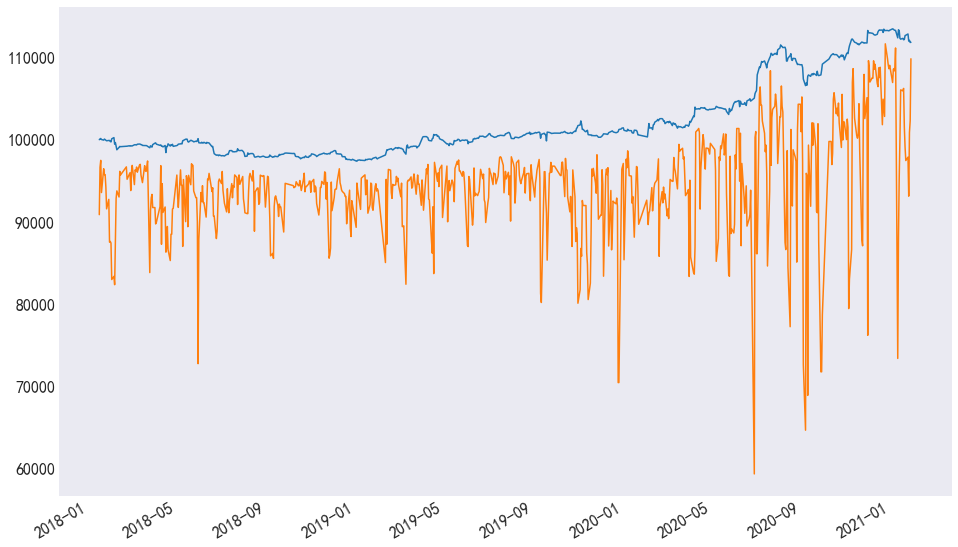

In [106]:
core.balance.sum(axis=1).plot()
core.balance.cash.plot()

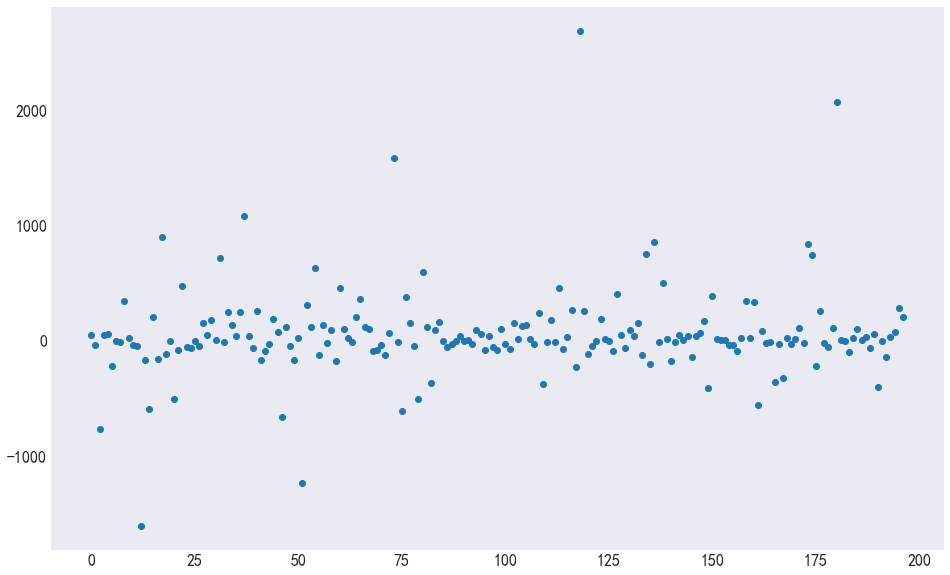

In [107]:
plt.scatter(np.arange(len(core.profit.sum().values)),core.profit.sum().values)

In [108]:
core.balance.sum(axis=1)

2018-01-16     99998.0
2018-01-17    100085.0
2018-01-18    100141.0
2018-01-19    100018.0
2018-01-22     99947.0
                ...   
2021-01-25    112866.0
2021-01-26    112002.0
2021-01-27    112094.0
2021-01-28    111837.0
2021-01-29    111852.0
Length: 740, dtype: float64

In [109]:
core.profit.sum().sort_values()

000538   -1605.0
002304   -1236.0
000063    -764.0
002230    -663.0
300122    -613.0
           ...  
000661     900.0
002049    1083.0
300033    1588.0
601888    2074.0
600436    2686.0
Length: 197, dtype: float64

In [110]:
import quantstats as qs
qs.extend_pandas()

In [111]:
value=core.balance.sum(axis=1)

In [112]:
drt=(value-value.shift(1))/value

In [113]:
value

2018-01-16     99998.0
2018-01-17    100085.0
2018-01-18    100141.0
2018-01-19    100018.0
2018-01-22     99947.0
                ...   
2021-01-25    112866.0
2021-01-26    112002.0
2021-01-27    112094.0
2021-01-28    111837.0
2021-01-29    111852.0
Length: 740, dtype: float64

In [114]:
qs.stats.sharpe(value)

0.9864255075184785

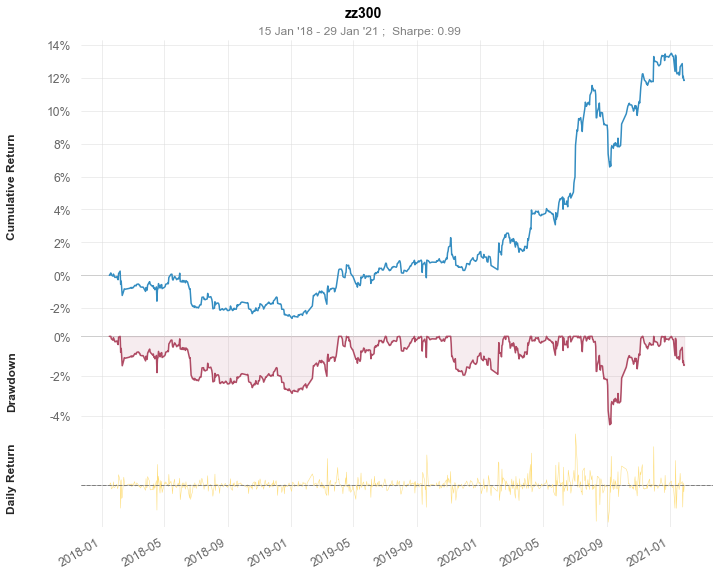

In [115]:
qs.plots.snapshot(value,title="zz300")